# Import & Settings

In [12]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

from IPython.display import clear_output
import matplotlib.pyplot as plt

import torch
device = torch.device("cuda")

### Setting

In [13]:
# Dataset
valid_rto = 0.3
batch_size = 16

# Model
d_model = 256
max_seq_len = 52
nhead = 8
d_ff = 512
dropout = 0.3
num_layers = 6

# Read and Split

In [14]:
# Splits by certain date
def split(data, rto, date_col):
    unique_date = data[date_col].unique()
    valid_size = int(len(unique_date) * rto)
    train_date = data[:-valid_size]
    valid_date = data[-valid_size:]
    return train_date, valid_date

In [15]:
# Test sin func
x = np.linspace(0, 2*np.pi, 10000)
y = np.sin(x)
sinfunc_raw = pd.DataFrame({"x":x, "y":y})
sinfunc_train, sinfunc_valid = split(sinfunc_raw, valid_rto, "x")

# Visuelle
visuelle_gtrend = pd.read_csv("../visuelle/gtrends.csv", parse_dates=["date"])
visuelle_raw = pd.read_csv("../visuelle/train.csv", parse_dates=["release_date"]).sort_values("release_date")
scaler = np.load("../visuelle/normalization_scale.npy")
visuelle_train, visuelle_valid = split(visuelle_raw, valid_rto, "release_date")
visuelle_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,external_code,season,category,release_date,day,week,month,year,image_path,color,fabric,extra
0,0.004695,0.073239,0.061972,0.066667,0.046009,0.043192,0.026291,0.019718,0.012207,0.014085,0.010329,0.009390,1,SS17,long sleeve,2016-12-01,0.500000,0.923077,1.0,0.998514,PE17/00001.png,yellow,acrylic,hem
1,0.005634,0.109859,0.128638,0.135211,0.082629,0.098592,0.063850,0.052582,0.034742,0.138967,0.159624,0.055399,2,SS17,long sleeve,2016-12-01,0.500000,0.923077,1.0,0.998514,PE17/00002.png,brown,acrylic,hem
2,0.002817,0.207512,0.177465,0.095775,0.041315,0.030047,0.015023,0.006573,0.010329,0.005634,0.002817,0.001878,3,SS17,culottes,2016-12-02,0.666667,0.923077,1.0,0.998514,PE17/00003.png,blue,scuba crepe,hem
3,0.000939,0.044131,0.046948,0.041315,0.028169,0.031925,0.031925,0.023474,0.016901,0.028169,0.020657,0.009390,4,SS17,long sleeve,2016-12-02,0.666667,0.923077,1.0,0.998514,PE17/00004.png,yellow,acrylic,sleeveless
4,0.006573,0.098592,0.125822,0.120188,0.068545,0.046948,0.043192,0.034742,0.030047,0.029108,0.033803,0.009390,5,SS17,long sleeve,2016-12-02,0.666667,0.923077,1.0,0.998514,PE17/00005.png,grey,acrylic,hem


# Make Dataset

### Sinfunc

In [16]:
# class SinfuncDataset(torch.utils.data.Dataset):
#     def __init__(self, data, window_size, pred_len):
#         self.data, self.window_size, self.pred_len = data, window_size, pred_len
#         self.x_li, self.y_li = self.preprocess(self.data)
    
#     def preprocess(self, data):
#         x_li, y_li = [], []
#         data = data["y"].values
#         for idx in range(0, data.shape[0], window_size+pred_len):
#             d = data[idx:idx+window_size+pred_len]
#             x = d[:window_size]
#             y = d[-pred_len:]

#             if len(x) == window_size:
#                 x_li.append(x)
#                 y_li.append(y)
#         return x_li, y_li
    
#     def __getitem__(self, idx):
#         return torch.FloatTensor(self.x_li[idx]), torch.FloatTensor(self.y_li[idx])

#     def __len__(self):
#         return len(self.x_li)

# sinfunc_train_dataset = SinfuncDataset(sinfunc_train, window_size, pred_len)
# sinfunc_train_dataloader = torch.utils.data.DataLoader(sinfunc_train_dataset, batch_size=batch_size, shuffle=True)

# sinfunc_valid_dataset = SinfuncDataset(sinfunc_valid, window_size, pred_len)
# sinfunc_valid_dataloader = torch.utils.data.DataLoader(sinfunc_valid_dataset, batch_size=1, shuffle=True)

### Visuelle

In [17]:
temp = None
class VisuelleDataset(torch.utils.data.Dataset):
    def __init__(self, data, gtrend, scaler):
        self.data = self.get_data(data, gtrend, scaler) # Preprocess data
    
    def get_data(self, data, gtrend, scaler):
        # Get data
        def func(x, gtrend, scaler):
            cat, release_date = x
            gtrend_start = release_date - pd.DateOffset(weeks=52)
            gtrend = gtrend[
                (gtrend["date"] >= gtrend_start) 
                &(gtrend["date"] < release_date)
                ][cat]
            # return gtrend.values / scaler
            return gtrend.values
        
        data = data.copy()
        data["gtrend"] = data[["category", "release_date"]].apply(lambda x: func(x, gtrend, scaler), axis=1)
        return data
    
    def __getitem__(self, idx):
        sales = self.data.iloc[:, :12].values
        gtrend = self.data["gtrend"].values
        gtrend = np.array([i for i in gtrend])
        
        return torch.FloatTensor(gtrend[idx]), torch.FloatTensor(sales[idx])
    
    def __len__(self):
        return len(self.data)

visuelle_train_dataset = VisuelleDataset(visuelle_train, visuelle_gtrend, scaler)
visuelle_train_dataloader = torch.utils.data.DataLoader(visuelle_train_dataset, batch_size=batch_size, shuffle=True)
# visuelle_train_dataloader = torch.utils.data.DataLoader(visuelle_train_dataset, batch_size=2, shuffle=True)

visuelle_valid_dataset = VisuelleDataset(visuelle_valid, visuelle_gtrend, scaler)
visuelle_valid_dataloader = torch.utils.data.DataLoader(visuelle_valid_dataset, batch_size=batch_size, shuffle=True)
next(iter(visuelle_train_dataloader))[0].shape

torch.Size([16, 52])

### Dataset setting

In [18]:
# train_dataloader = sinfunc_train_dataloader
# valid_dataloader = sinfunc_valid_dataloader

train_dataloader = visuelle_train_dataloader
valid_dataloader = visuelle_valid_dataloader

# Architecture

### LSTM

In [19]:
# class LSTM(torch.nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super().__init__()
#         self.lstm1 = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size)
#         self.lstm2 = torch.nn.RNN(input_size=hidden_size, hidden_size=hidden_size)
#         self.lstm3 = torch.nn.RNN(input_size=hidden_size, hidden_size=hidden_size)
#         self.linear = torch.nn.Linear(hidden_size, output_size)

#     def forward(self, data):
#         output, _ = self.lstm1(data)
#         output, _ = self.lstm2(output)
#         output, _ = self.lstm3(output)
#         output = self.linear(output)
#         return output

# model = LSTM(input_size=1, hidden_size=hidden_size, output_size=pred_len)
# model.to(device)

### Transformer

In [20]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, max_len, d_model, dropout):
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)

        position = torch.arange(max_len).reshape(-1,1).to(device)
        i = torch.arange(d_model).to(device)//2
        exp_term = 2*i/d_model
        div_term = torch.pow(10000, exp_term).reshape(1, -1)
        self.pos_encoded = position / div_term

        self.pos_encoded[:, 0::2] = torch.sin(self.pos_encoded[:, 0::2])
        self.pos_encoded[:, 1::2] = torch.cos(self.pos_encoded[:, 1::2])

    def forward(self, x):
        output = x + self.pos_encoded[:x.shape[1], :]
        return self.dropout(output)

class Mask(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def get_padding_mask(self, arr):
        res = torch.eq(arr, 0).type(torch.FloatTensor).to(device)
        res = torch.where(res==1, -torch.inf, 0)
        return res
    
    def get_lookahead_mask(self, arr):
        seq_len = arr.shape[1]
        mask = torch.triu(torch.ones((seq_len, seq_len))*-torch.inf, 1).to(device)
        return mask

    def forward(self, arr):
        padding_mask = self.get_padding_mask(arr)
        lookahead_mask = self.get_lookahead_mask(arr)
        return padding_mask, lookahead_mask


In [21]:
class Transformer(torch.nn.Module):
    def __init__(self, d_model, max_seq_len, nhead, num_layers, d_ff=512, dropout=0.3):
        super().__init__()
        self.enc_mask = Mask()
        self.enc_embedding = torch.nn.Linear(1, d_model)
        self.enc_pos_encoding = PositionalEncoding(max_seq_len, d_model, dropout)
        self.encoder = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model, nhead, d_ff, dropout, batch_first=True), num_layers)

        self.dec_mask = Mask()
        self.dec_embedding = torch.nn.Linear(1, d_model)
        self.dec_pos_encoding = PositionalEncoding(max_seq_len, d_model, dropout)
        self.decoder = torch.nn.TransformerDecoder(torch.nn.TransformerDecoderLayer(d_model, nhead, d_ff, dropout, batch_first=True), num_layers)
        
        self.linear = torch.nn.Linear(d_model, 1)
        
    def forward(self, enc_input, dec_input):
        enc_padding_mask, _ = self.enc_mask(enc_input.squeeze())
        enc_output = self.enc_embedding(enc_input)
        enc_output = self.enc_pos_encoding(enc_output)
        
        enc_output = self.encoder(enc_output)

        dec_padding_mask, dec_lookahead_mask = self.dec_mask(dec_input.squeeze())
        dec_output = self.dec_embedding(dec_input)
        dec_output = self.dec_pos_encoding(dec_output)

        dec_output = self.decoder(tgt=dec_output, memory=enc_output, tgt_mask=dec_lookahead_mask)

        output = torch.nn.ReLU()(self.linear(dec_output))

        return output

model = Transformer(d_model, max_seq_len, nhead, num_layers, d_ff, dropout)
model.to(device)

Transformer(
  (enc_mask): Mask()
  (enc_embedding): Linear(in_features=1, out_features=256, bias=True)
  (enc_pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (dec_mask): Mask()
  (dec_embedding): Linear(in_features=1, out_features=256, bias=True)
  (dec_po

# Train

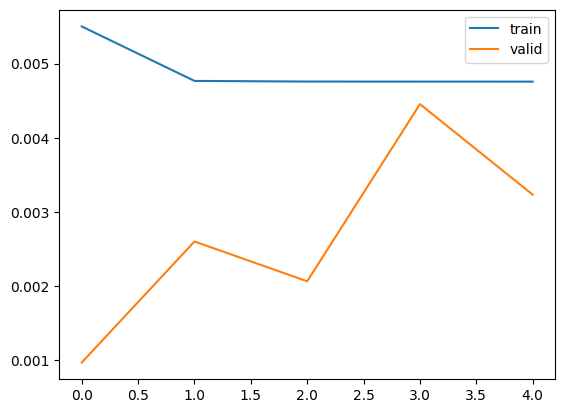

 5:147/303 mean_loss: 0.0045802655379678055

KeyboardInterrupt: 

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = torch.nn.MSELoss()

def train(epoch):
    model.train()
    total_len = len(train_dataloader)
    total_loss = 0
    for n, data in enumerate(train_dataloader):
        x, y = data
        
        # Train
        optimizer.zero_grad()
        pred = model(x.unsqueeze(-1).to(device), y.unsqueeze(-1).to(device)).squeeze()
        loss = loss_fn(pred, y.to(device))
        loss.backward()
        optimizer.step()

        # Report
        total_loss += loss.item()
        mean_loss = total_loss / (n+1)
        print(f"\r {epoch}:{n}/{total_len} mean_loss: {mean_loss}", end="")

    print()
    return mean_loss

def val():
    model.eval()
    total_len = len(valid_dataloader)
    total_loss = 0
    for n, data in enumerate(valid_dataloader):
        x, y = data
        
        # Pred
        with torch.no_grad():
            pred = model(x.unsqueeze(-1).to(device), y.unsqueeze(-1).to(device)).squeeze()
            loss = loss_fn(pred, y.to(device))

            # Report
            total_loss += loss.item()
            mean_loss = total_loss / (n+1)
            return mean_loss
 
def plot(train_loss_li, val_loss_li):
    # Plot loss
    clear_output(wait=True)
    plt.plot(train_loss_li, label="train")
    plt.plot(val_loss_li, label="valid")
    plt.legend()
    plt.show()   

epoch = 1000
train_loss_li, val_loss_li = [], []
for e in range(epoch):
    train_loss = train(e) # Train
    val_loss = val()

    train_loss_li.append(train_loss)
    val_loss_li.append(val_loss)
    plot(train_loss_li, val_loss_li)